# Fit using polynomialand zeta function

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) + a_3(1/n_v) + a_4(1/n_v)^2 + a_5(1/n_v)^{3} + a_6(1/n_v)^4 $$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [24]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res

In [221]:
def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2,a3,a4,a5,a6 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2)) + a3*x + a4*(x)**2 + a5*x**3+a6*x**4

In [222]:
def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [223]:
def residuals_func(coefs,x,fi):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns an array with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    residuals = fi - model_function(
        x,
        coefs
    )
    return residuals

def residuals_func_sum_sqr(coefs):
    """Calculate the sum of the squared residuals."""
    result = 0
    num_el = len(x_data)
    for index in range(num_el):
        result = result + residuals_func(coefs,x_data[index],y_data[index])**2
    return result

## Read files

In [164]:
data_path = Path("../../../data/").resolve()
file = 'all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [165]:
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.671622,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.516743,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.438057,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.389057,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.354681,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.328996,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.308949,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.292798,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.279327,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.267970,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [224]:
df_params = pd.DataFrame(index=["a1","a2","a3","a4","a5","a6"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

      fun: 0.0009138617943700904
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.38033313e-04, 1.66482892e-03, 9.04279689e-05, 5.82369981e-05,
       7.22389488e-05, 4.89346519e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 287
      nit: 34
   status: 0
  success: True
        x: array([ 0.5904582 ,  1.        ,  0.62377567,  0.27084245, -1.39991454,
        1.11442067])
Best fit parameters: [ 0.5904582   1.          0.62377567  0.27084245 -1.39991454  1.11442067]


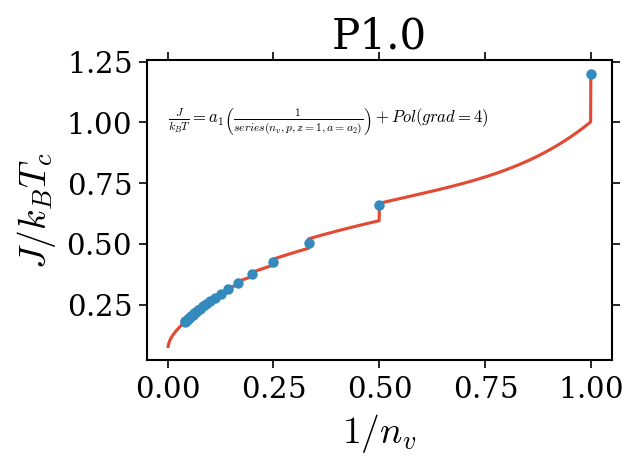

---------------------------------------------
coefs:[ 0.5904582   1.          0.62377567  0.27084245 -1.39991454  1.11442067]
---------------------------------------------
min:0.0795046145512349 at 0.001
fit at 1/nv=1: 1.199582452212919


      fun: 0.001217325430179823
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.97544957e-03,  2.19913098e-03,  1.28370838e-04, -1.00890030e-03,
        8.06423721e-05,  9.48989867e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 266
      nit: 28
   status: 0
  success: True
        x: array([ 0.56680268,  1.07149974,  0.71847239,  0.        , -1.43916805,
        1.3118383 ])
Best fit parameters: [ 0.56680268  1.07149974  0.71847239  0.         -1.43916805  1.3118383 ]


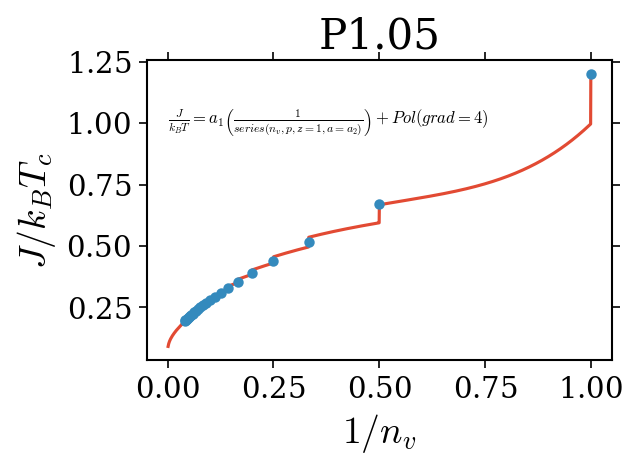

---------------------------------------------
coefs:[ 0.56680268  1.07149974  0.71847239  0.         -1.43916805  1.3118383 ]
---------------------------------------------
min:0.09056822077258722 at 0.001
fit at 1/nv=1: 1.2005722846481912


      fun: 0.0009100244237577715
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.75386960e-05, 1.72438932e-03, 3.45558760e-05, 1.38022840e-05,
       3.10977806e-05, 3.75862536e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 308
      nit: 38
   status: 0
  success: True
        x: array([ 0.61907938,  1.        ,  0.6214056 ,  0.21211512, -1.35340386,
        1.10036205])
Best fit parameters: [ 0.61907938  1.          0.6214056   0.21211512 -1.35340386  1.10036205]


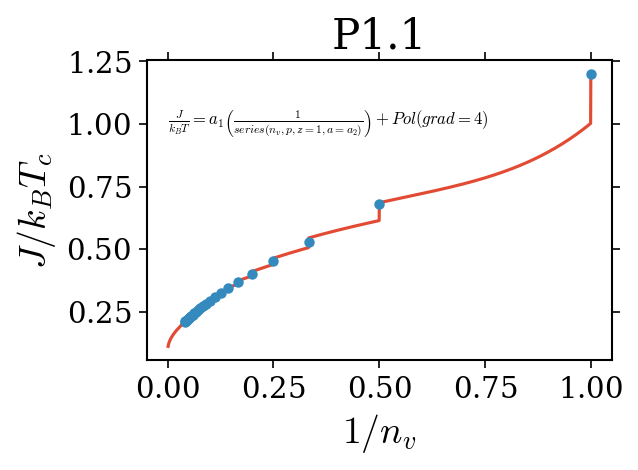

---------------------------------------------
coefs:[ 0.61907938  1.          0.6214056   0.21211512 -1.35340386  1.10036205]
---------------------------------------------
min:0.1117105520733036 at 0.001
fit at 1/nv=1: 1.1995582918447214


      fun: 0.0007725102855368383
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.35743628e-07,  1.49817592e-03,  1.12155294e-06,  3.18928911e-06,
       -1.90594068e-06, -3.51460397e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 329
      nit: 41
   status: 0
  success: True
        x: array([ 0.65361768,  1.        ,  0.57511957,  0.25376781, -1.36014175,
        1.07724452])
Best fit parameters: [ 0.65361768  1.          0.57511957  0.25376781 -1.36014175  1.07724452]


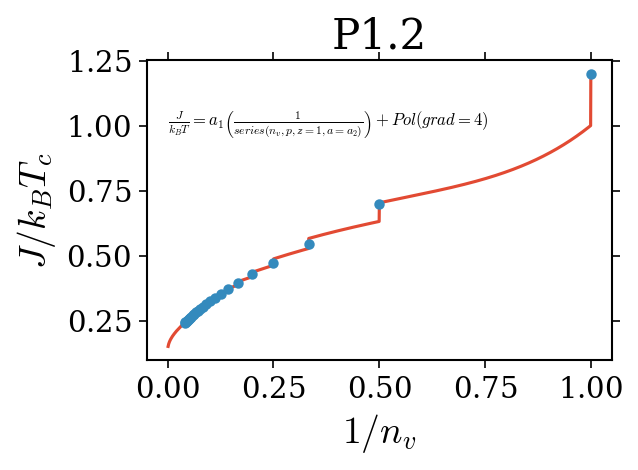

---------------------------------------------
coefs:[ 0.65361768  1.          0.57511957  0.25376781 -1.36014175  1.07724452]
---------------------------------------------
min:0.15132563417158948 at 0.001
fit at 1/nv=1: 1.19960783200862


      fun: 0.0009061751238008573
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.47909635e-07,  1.76976385e-03, -3.21986361e-06, -4.41644334e-06,
        1.26955738e-05, -5.63604068e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 357
      nit: 43
   status: 0
  success: True
        x: array([ 0.68035213,  1.        ,  0.56350747,  0.27628173, -1.48676704,
        1.16619626])
Best fit parameters: [ 0.68035213  1.          0.56350747  0.27628173 -1.48676704  1.16619626]


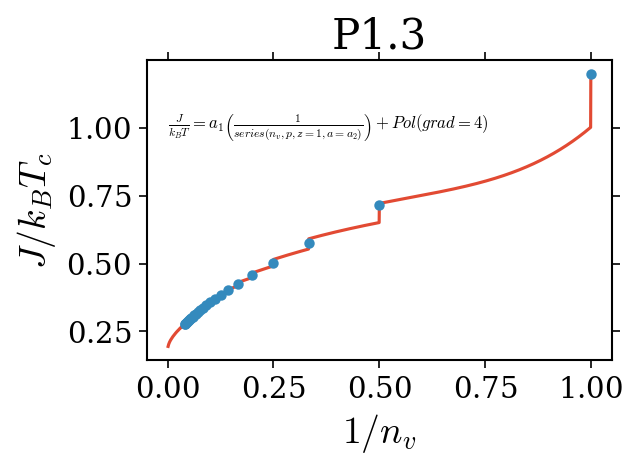

---------------------------------------------
coefs:[ 0.68035213  1.          0.56350747  0.27628173 -1.48676704  1.16619626]
---------------------------------------------
min:0.19426548834372967 at 0.001
fit at 1/nv=1: 1.1995705473593203


      fun: 0.0008045691490950609
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.55986616e-05,  1.71642064e-03,  1.01928882e-05,  3.28363638e-06,
        1.55253414e-05, -3.11891355e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 378
      nit: 43
   status: 0
  success: True
        x: array([ 0.70963165,  1.        ,  0.53814092,  0.2746763 , -1.48766852,
        1.16479929])
Best fit parameters: [ 0.70963165  1.          0.53814092  0.2746763  -1.48766852  1.16479929]


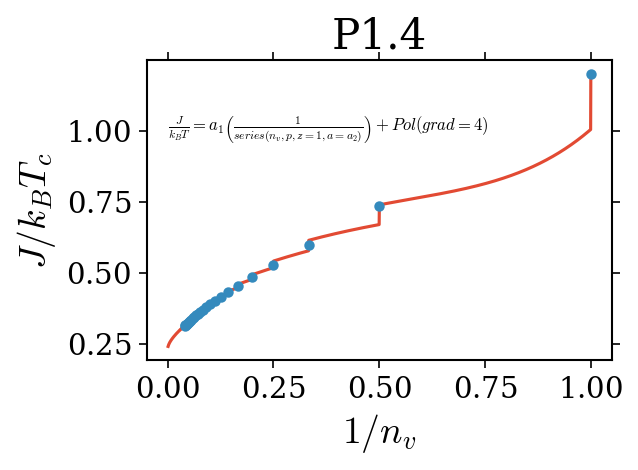

---------------------------------------------
coefs:[ 0.70963165  1.          0.53814092  0.2746763  -1.48766852  1.16479929]
---------------------------------------------
min:0.24126782160704144 at 0.001
fit at 1/nv=1: 1.199579633046625


      fun: 0.0007339598545074214
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.76588269e-04, 1.80635478e-03, 7.41465483e-05, 3.84835610e-05,
       5.16086956e-05, 2.88653975e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 392
      nit: 45
   status: 0
  success: True
        x: array([ 0.73989256,  1.        ,  0.50385493,  0.25681992, -1.40671114,
        1.10573722])
Best fit parameters: [ 0.73989256  1.          0.50385493  0.25681992 -1.40671114  1.10573722]


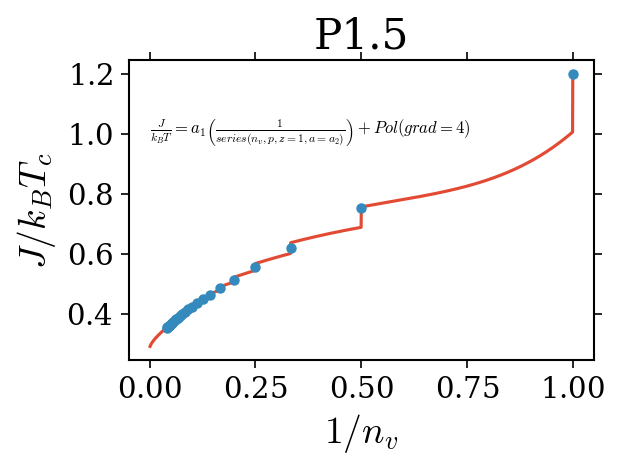

---------------------------------------------
coefs:[ 0.73989256  1.          0.50385493  0.25681992 -1.40671114  1.10573722]
---------------------------------------------
min:0.29075530543600453 at 0.001
fit at 1/nv=1: 1.1995934804882382


      fun: 0.0007064615253696255
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.47709706e-05, 1.74780808e-03, 2.85354639e-05, 3.19818499e-05,
       5.82223289e-05, 3.56496733e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 399
      nit: 48
   status: 0
  success: True
        x: array([ 0.77279097,  1.        ,  0.43984357,  0.32839492, -1.39661722,
        1.05518333])
Best fit parameters: [ 0.77279097  1.          0.43984357  0.32839492 -1.39661722  1.05518333]


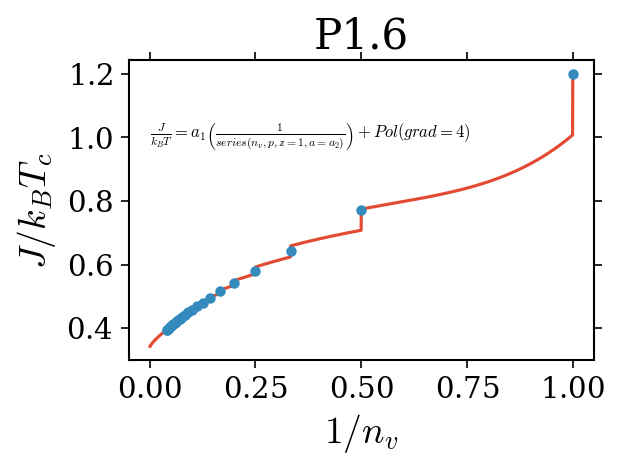

---------------------------------------------
coefs:[ 0.77279097  1.          0.43984357  0.32839492 -1.39661722  1.05518333]
---------------------------------------------
min:0.34248013431325974 at 0.001
fit at 1/nv=1: 1.1995955650909342


      fun: 0.0006250564930963637
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.61305688e-06,  1.45589298e-03, -4.01361886e-06, -6.72234620e-06,
       -7.18600526e-06, -7.37519854e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 539
      nit: 67
   status: 0
  success: True
        x: array([ 0.81479133,  1.        ,  0.24909081,  1.1388305 , -2.87729437,
        1.87419879])
Best fit parameters: [ 0.81479133  1.          0.24909081  1.1388305  -2.87729437  1.87419879]


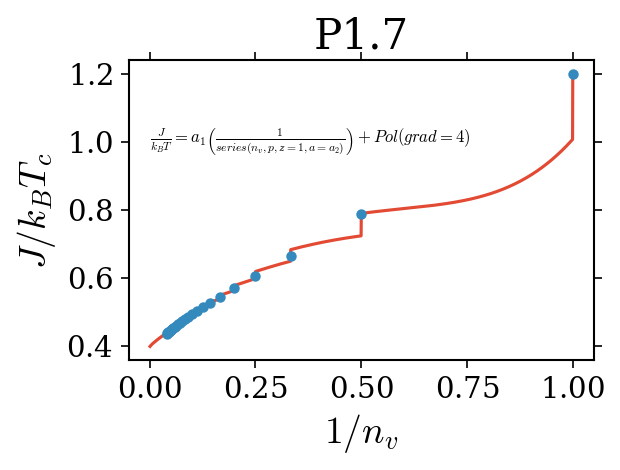

---------------------------------------------
coefs:[ 0.81479133  1.          0.24909081  1.1388305  -2.87729437  1.87419879]
---------------------------------------------
min:0.39908194395303187 at 0.001
fit at 1/nv=1: 1.1996170614148818


      fun: 0.0005818871296407209
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.28454191e-05,  1.57757838e-03, -2.41969639e-05, -3.08097948e-05,
        9.76591854e-06, -2.82931881e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 469
      nit: 57
   status: 0
  success: True
        x: array([ 0.83896974,  1.        ,  0.2845006 ,  0.53805064, -1.4662228 ,
        1.0042487 ])
Best fit parameters: [ 0.83896974  1.          0.2845006   0.53805064 -1.4662228   1.0042487 ]


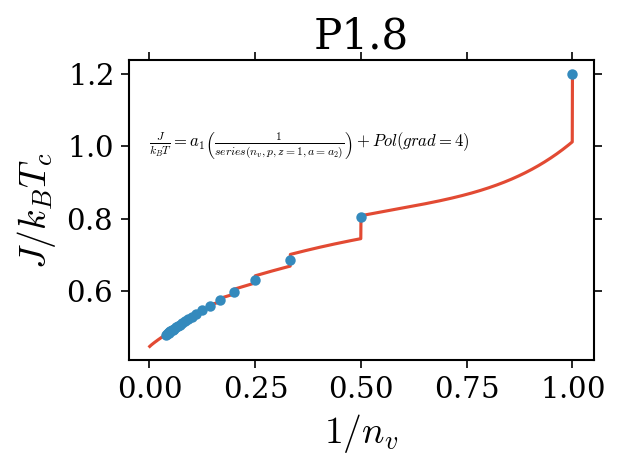

---------------------------------------------
coefs:[ 0.83896974  1.          0.2845006   0.53805064 -1.4662228   1.0042487 ]
---------------------------------------------
min:0.4471980141562116 at 0.001
fit at 1/nv=1: 1.1995468762329717


      fun: 0.0005362801606670543
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.34841224e-05,  1.49971611e-03, -4.29378321e-05, -4.88478182e-05,
        8.40924552e-06, -4.75305559e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 371
      nit: 48
   status: 0
  success: True
        x: array([ 0.87103495,  1.        ,  0.20295108,  0.60985243, -1.35689589,
        0.87257067])
Best fit parameters: [ 0.87103495  1.          0.20295108  0.60985243 -1.35689589  0.87257067]


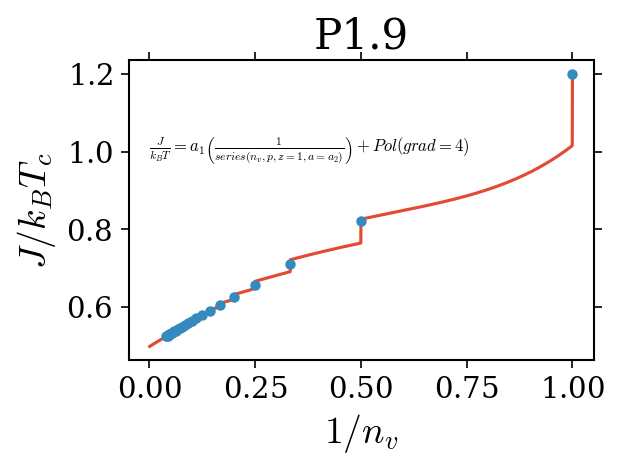

---------------------------------------------
coefs:[ 0.87103495  1.          0.20295108  0.60985243 -1.35689589  0.87257067]
---------------------------------------------
min:0.4986411903444301 at 0.001
fit at 1/nv=1: 1.1995132408141083


      fun: 0.0005967747699409258
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.02525995e-04,  1.98590431e-03,  4.91335054e-05, -4.75512641e-06,
        5.42110302e-05, -2.93461110e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 469
      nit: 57
   status: 0
  success: True
        x: array([ 0.90233153,  1.        ,  0.10938703,  0.76529255, -1.44321483,
        0.86569115])
Best fit parameters: [ 0.90233153  1.          0.10938703  0.76529255 -1.44321483  0.86569115]


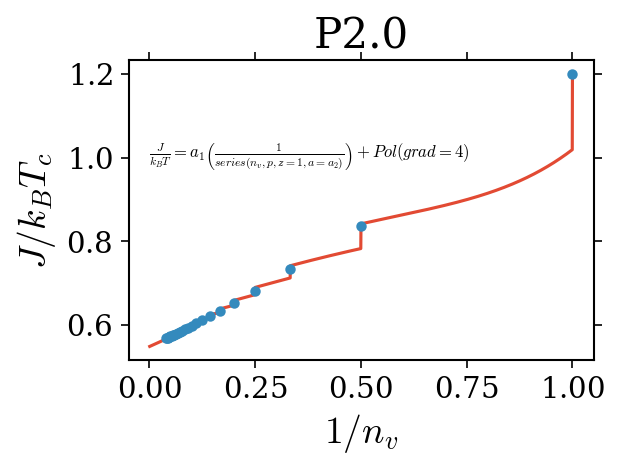

---------------------------------------------
coefs:[ 0.90233153  1.          0.10938703  0.76529255 -1.44321483  0.86569115]
---------------------------------------------
min:0.5489954557441292 at 0.001
fit at 1/nv=1: 1.199487421759279




In [234]:
epsilon = 0.0001
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_polynomial_and_gen_zeta_6_parms'
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)
        
    # fit 
    best_fit_result = minimize(residuals_func_sum_sqr,
                               x0=(1,1.5, 1, 0.5, 1, 3),
                              bounds = ((0.1,2),(1, 3), (None, None),(0,None),(None,None),(0,None))
                              )
    print(best_fit_result)
    best_fit_coefs = best_fit_result.x
    print("Best fit parameters:", best_fit_coefs)

#     (a1,a2) = best_fit_coefs 
    df_params[COLUMN] = best_fit_coefs
    extrapol_funct = get_extrapol_function(model_function, best_fit_coefs)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1, 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) + Pol(grad=4)$",
           fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_coefs))
    print("---------------------------------------------")
    df_extrapol_val[COLUMN] = [extrapol_funct(0+epsilon),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")


In [226]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [211]:
print(np.arange(1,2.1,0.1))
print(1.036694*zeta(np.arange(1,2.1,0.1),1.005401))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
[        inf 10.96326581  5.78679131  4.06585347  3.20871592  2.69703051
  2.35801395  2.1176159   1.938811    1.80102955  1.69192972]


In [227]:
1/df_extrapol_val

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,inf,13.831869,17.097078,8.554821,5.779286,4.376281,3.530750,2.957806,2.521245,2.243501,2.008813,1.822982
1,0.833623,0.832936,0.833640,0.833606,0.833632,0.833625,0.833616,0.833614,0.833599,0.833648,0.833671,0.833689


In [228]:
df_params

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,0.590458,0.566803,0.619079,0.653618,0.680352,0.709632,0.739893,0.772791,0.814791,0.838970,0.871035,0.902332
a2,1.000000,1.071500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a3,0.623776,0.718472,0.621406,0.575120,0.563507,0.538141,0.503855,0.439844,0.249091,0.284501,0.202951,0.109387
a4,0.270842,0.000000,0.212115,0.253768,0.276282,0.274676,0.256820,0.328395,1.138831,0.538051,0.609852,0.765293
a5,-1.399915,-1.439168,-1.353404,-1.360142,-1.486767,-1.487669,-1.406711,-1.396617,-2.877294,-1.466223,-1.356896,-1.443215
a6,1.114421,1.311838,1.100362,1.077245,1.166196,1.164799,1.105737,1.055183,1.874199,1.004249,0.872571,0.865691


In [229]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_polynomial_and_gen_zeta_6_parms'

In [230]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1  0.590458  0.566803  0.619079  0.653618  0.680352  0.709632  0.739893   
a2  1.000000  1.071500  1.000000  1.000000  1.000000  1.000000  1.000000   
a3  0.623776  0.718472  0.621406  0.575120  0.563507  0.538141  0.503855   
a4  0.270842  0.000000  0.212115  0.253768  0.276282  0.274676  0.256820   
a5 -1.399915 -1.439168 -1.353404 -1.360142 -1.486767 -1.487669 -1.406711   
a6  1.114421  1.311838  1.100362  1.077245  1.166196  1.164799  1.105737   

        P1.6      P1.7      P1.8      P1.9      P2.0  
a1  0.772791  0.814791  0.838970  0.871035  0.902332  
a2  1.000000  1.000000  1.000000  1.000000  1.000000  
a3  0.439844  0.249091  0.284501  0.202951  0.109387  
a4  0.328395  1.138831  0.538051  0.609852  0.765293  
a5 -1.396617 -2.877294 -1.466223 -1.356896 -1.443215  
a6  1.055183  1.874199  1.004249  0.872571  0.865691  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\D

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


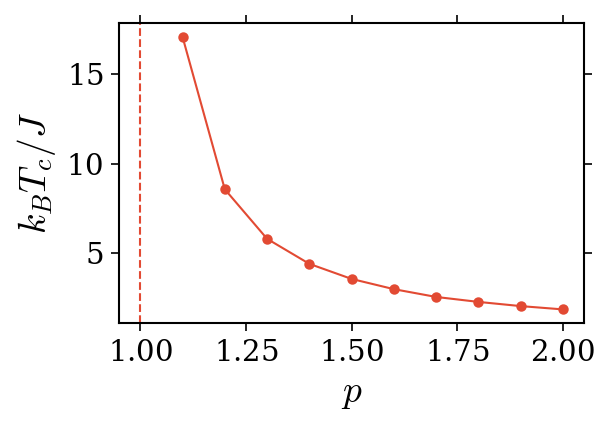

In [233]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values
y_data = np.delete(y_data,1)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()

In [44]:
help(ax.text)

Help on method text in module matplotlib.axes._axes:

text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add text to the axes.
    
    Add the text *s* to the axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : scalars
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Returns
    -------
    text : `.Text`
        The created `.Text` instance.
   